In [1]:
import kagglehub

# Download CIFAR-10
# path = kagglehub.dataset_download("pankrzysiu/cifar10-python") + '/cifar-10-batches-py'
path = '/home/tibless/.cache/kagglehub/datasets/pankrzysiu/cifar10-python/versions/1' + '/cifar-10-batches-py'

print("Path to dataset files:", path)

Path to dataset files: /home/tibless/.cache/kagglehub/datasets/pankrzysiu/cifar10-python/versions/1/cifar-10-batches-py


In [2]:
import os
import numpy as np

import jax.numpy as jnp
from jax import jit, random

key = random.PRNGKey(42)

class2name = [
    'airplane',  # 0
    'automobile',  # 1
    'bird',  # 2
    'cat',  # 3
    'deer',  # 4
    'dog',  # 5
    'frog',  # 6
    'horse',  # 7
    'ship',  # 8
    'truck'  # 9
]

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(path):
    x_train = []
    y_train = []
    
    for i in range(1, 6):
        file_path = os.path.join(path, f'data_batch_{i}')
        data_dict = unpickle(file_path)
        
        x_train.append(data_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1))
        y_train += data_dict[b'labels']
    
    x_train = np.vstack(x_train)
    y_train = np.array(y_train)

    test_file_path = os.path.join(path, 'test_batch')
    test_dict = unpickle(test_file_path)
    
    x_test = test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_dict[b'labels'])

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_cifar10(path)

print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000,)
Testing data shape: (10000, 32, 32, 3), Testing labels shape: (10000,)


In [3]:
from plugins.minitorch.utils import one_hot

TRAIN = 5000
TEST = 1000
x_train = x_train[:TRAIN].transpose(0, 3, 1, 2) / 255.
y_train = y_train[:TRAIN]
x_test = x_test[:TEST].transpose(0, 3, 1, 2) / 255.
y_test = y_test[:TEST]

x_train = jnp.array(x_train)
y_train = jnp.array(y_train)
x_test = jnp.array(x_test)
y_test = jnp.array(y_test)

y_train_one_hot = one_hot(y_train, 10)
y_test_one_hot = one_hot(y_test, 10)

In [4]:
import jax.numpy as jnp

from plugins.minitorch.initer import Initer
from plugins.minitorch.optimizer import Adam
from plugins.minitorch.nn import Conv
from plugins.minitorch.utils import l2_regularization, softmax, cross_entropy_loss

class LeNet:
    def __init__(self, lr=0.01, batch_size=32):
        self.config = {
            'conv2d4relu:0' : {
                'input_channel': 3,
                'output_channel': 6*3,
                'kernel_size': 5,
                'padding': 0,
            },
            'max_pooling:0' : {
                'window_size': 2,
            },
            'conv2d4relu:1' : {
                'input_channel': 6*3,
                'output_channel': 16*3,
                'kernel_size': 5,
                'padding': 0,
            },
            'max_pooling:1' : {
                'window_size': 2,
            },
            'fc4relu:0' : {
                'input_dim': 3*16*5*5,
                'output_dim': 120,
            },
            'fc4relu:1' : {
                'input_dim': 120,
                'output_dim': 84,
            },
            'fc4relu:2' : {
                'input_dim': 84,
                'output_dim': 10,
            },
        }

        initer = Initer(self.config, key)
        self.optr = Adam(initer(), lr=lr, batch_size=batch_size)

    def predict_proba(self, x: jnp.ndarray, params, train=True):
        res = Conv.conv2d(x, params['conv2d4relu:0']['w'], params['conv2d4relu:0']['b'], padding=self.config['conv2d4relu:0']['padding'])
        res = jnp.maximum(0, res)
        res = Conv.max_pooling2d(res, pool_size=(
            self.config['max_pooling:0']['window_size'],
            self.config['max_pooling:0']['window_size'],
        ))
        
        res = Conv.conv2d(res, params['conv2d4relu:1']['w'], params['conv2d4relu:1']['b'], padding=self.config['conv2d4relu:1']['padding'])
        res = jnp.maximum(0, res)
        res = Conv.max_pooling2d(res, pool_size=(
            self.config['max_pooling:1']['window_size'],
            self.config['max_pooling:1']['window_size'],
        ))

        res = res.reshape(res.shape[0], -1)

        res = res @ params['fc4relu:0']['w'] + params['fc4relu:0']['b']
        res = jnp.maximum(0, res)
        
        res = res @ params['fc4relu:1']['w'] + params['fc4relu:1']['b']
        res = jnp.maximum(0, res)
        
        res = res @ params['fc4relu:2']['w'] + params['fc4relu:2']['b']

        return softmax(res)
       
    def fit(self, x_train, y_train_proba, x_test, y_test_proba, epoches=100): 
        cnt = 0

        @jit
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return jnp.mean(y_true == y_pred)

        _loss = lambda params, x, y_true: cross_entropy_loss(y_true, self.predict_proba(x, params, True)) 
        _loss = jit(_loss)  # accelerate loss function by JIT
        self.optr.open(_loss, x_train, y_train_proba)
        
        _tloss = lambda params: cross_entropy_loss(y_test_proba, self.predict_proba(x_test, params, False)) 
        _tloss = jit(_tloss)  # accelerate loss function by JIT
        

        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss

        for _ in range(epoches):
            loss.append(_loss(self.optr.get_params(), x_train, y_train_proba))
            tloss.append(_tloss(self.optr.get_params()))

            self.train = True  # use dropout only while updating grads
            self.optr.update()
            self.train = False
            
            acc.append(_acc(y_train_proba, self.predict_proba(x_train, self.optr.get_params())))
            tacc.append(_acc(y_test_proba, self.predict_proba(x_test, self.optr.get_params())))
            cnt += 1
            if cnt % 10 == 0:
                print(f'>> epoch: {cnt}, train acc: {acc[-1]}, test acc: {tacc[-1]}')

        return acc, loss, tacc, tloss

In [5]:
epochs = 50
learning_rate = 0.005
batch_size = 128

model = LeNet(lr=learning_rate, batch_size=batch_size)

acc, loss, tacc, tloss = model.fit(
    x_train=x_train, 
    y_train_proba=y_train_one_hot,
    x_test=x_test,
    y_test_proba=y_test_one_hot,
    epoches=epochs)

[*] oprimizer opened with 39 batches with batch size 128.
>> epoch: 10, train acc: 0.5040000081062317, test acc: 0.4240000247955322
>> epoch: 20, train acc: 0.5230000019073486, test acc: 0.39000001549720764
>> epoch: 30, train acc: 0.6082000136375427, test acc: 0.37400001287460327
>> epoch: 40, train acc: 0.6229999661445618, test acc: 0.36000001430511475
>> epoch: 50, train acc: 0.8065999746322632, test acc: 0.3760000169277191


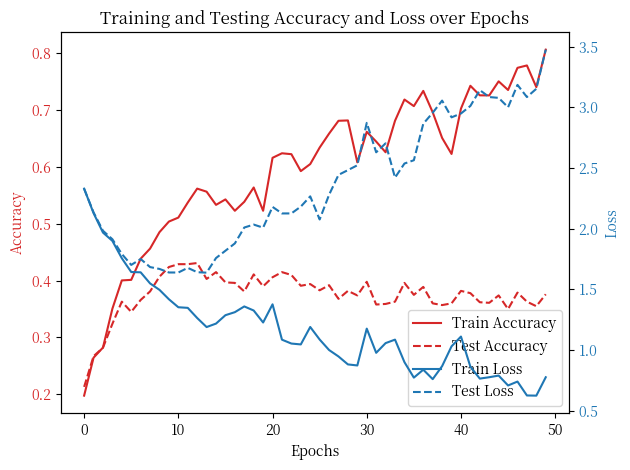

final train, test acc : 0.8065999746322632, 0.3760000169277191
final train, test loss: 0.776089608669281, 3.475956678390503


In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
# plt.savefig('./assets/LeNet_cifar10.png')
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')